# 05 Batch Size Sweep

Find optimal batch size for M4 Pro hardware.

**Goal:** Understand the tradeoff between throughput (steps/sec) and learning quality (loss at step 2000).

**Hypothesis:** Smaller batches → faster steps but noisier gradients → slower learning per step.

| Run | Batch Size | Tokens/Step | Hypothesis |
|-----|------------|-------------|------------|
| A | 1 | 512 | Very fast, very noisy, might not learn |
| B | 2 | 1,024 | Fast, noisy |
| C | 4 | 2,048 | Faster than 16, maybe learns? |
| D | 8 | 4,096 | Might be sweet spot |
| E | 16 | 8,192 | Known to work (from notebook 03/04) |
| F | 32 | 16,384 | More stable, slower steps |
| G | 64 | 32,768 | Most stable, slowest steps |

In [1]:
# === Parameters ===

# Fixed architecture (from notebook 04 winner)
VOCAB_SIZE = 8192
N_EMBD = 128
N_HEAD = 2
N_LAYER = 2  # Winner from layer sweep
N_POSITIONS = 512
N_INNER = 512

# Variable: batch sizes to test
BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64]

# Training
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
SEED = 42

# Run length
STEPS = 2000

# Paths
DATASET_PATH = "tokenized_dataset"

In [2]:
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_from_disk
from transformers import (
    GPT2Config,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_callback import TrainerCallback

print("Imports complete.")

Imports complete.


In [3]:
# Load dataset
dataset = load_from_disk(DATASET_PATH)
print(f"Dataset: {len(dataset):,} sequences")

# Collator
class CausalLMCollator:
    def __call__(self, examples):
        input_ids = torch.tensor([ex["input_ids"] for ex in examples], dtype=torch.long)
        return {"input_ids": input_ids, "labels": input_ids.clone()}

collator = CausalLMCollator()

Dataset: 921,519 sequences


In [4]:
class LossTracker(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

def run_experiment(batch_size):
    """Run a single training experiment with given batch size."""
    tokens_per_step = batch_size * N_POSITIONS
    print(f"\n{'='*50}")
    print(f"Running: batch_size = {batch_size} ({tokens_per_step:,} tokens/step)")
    print(f"{'='*50}")
    
    # Fresh model
    set_seed(SEED)
    config = GPT2Config(
        vocab_size=VOCAB_SIZE,
        n_embd=N_EMBD,
        n_head=N_HEAD,
        n_layer=N_LAYER,
        n_positions=N_POSITIONS,
        n_inner=N_INNER,
        activation_function='gelu',
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        use_cache=False,
    )
    model = GPT2LMHeadModel(config)
    
    # Training args
    args = TrainingArguments(
        output_dir=f"sweep_batch_{batch_size}",
        overwrite_output_dir=True,
        max_steps=STEPS,
        per_device_train_batch_size=batch_size,
        learning_rate=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY,
        max_grad_norm=MAX_GRAD_NORM,
        bf16=True,  # Proper mixed precision
        optim="adamw_torch",
        lr_scheduler_type="linear",
        warmup_steps=0,
        logging_steps=50,
        logging_first_step=True,
        report_to="none",
        save_strategy="no",
        dataloader_num_workers=0,
        seed=SEED,
    )
    
    # Train
    tracker = LossTracker()
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=dataset,
        data_collator=collator,
        callbacks=[tracker],
    )
    
    start = time.time()
    trainer.train()
    elapsed = time.time() - start
    
    steps_per_sec = STEPS / elapsed
    tokens_per_sec = tokens_per_step * steps_per_sec
    final_loss = tracker.losses[-1]
    total_tokens = tokens_per_step * STEPS
    
    print(f"\nResults:")
    print(f"  Time: {elapsed:.1f}s")
    print(f"  Steps/sec: {steps_per_sec:.1f}")
    print(f"  Tokens/sec: {tokens_per_sec:,.0f}")
    print(f"  Final loss: {final_loss:.4f}")
    print(f"  Total tokens: {total_tokens:,}")
    
    return {
        "batch_size": batch_size,
        "tokens_per_step": tokens_per_step,
        "steps_per_sec": steps_per_sec,
        "tokens_per_sec": tokens_per_sec,
        "final_loss": final_loss,
        "total_tokens": total_tokens,
        "losses": tracker.losses,
        "steps": tracker.steps,
    }

In [5]:
# Run all experiments
results = []
for batch_size in BATCH_SIZES:
    result = run_experiment(batch_size)
    results.append(result)


Running: batch_size = 1 (512 tokens/step)


/Users/jefferyharrell/Workshop/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,8.999800
50,8.469600
100,7.664200
150,7.014000
200,6.555000
250,6.210400
300,5.957800
350,5.793400
400,5.699500
450,5.580400



Results:
  Time: 26.5s
  Steps/sec: 75.5
  Tokens/sec: 38,653
  Final loss: 4.7645
  Total tokens: 1,024,000

Running: batch_size = 2 (1,024 tokens/step)


Step,Training Loss
1,9.001700
50,8.436200
100,7.629300
150,6.978100
200,6.502600
250,6.146300
300,5.905300
350,5.703700
400,5.546200
450,5.422100



Results:
  Time: 26.5s
  Steps/sec: 75.5
  Tokens/sec: 77,311
  Final loss: 4.5844
  Total tokens: 2,048,000

Running: batch_size = 4 (2,048 tokens/step)


Step,Training Loss
1,9.004900
50,8.411300
100,7.584500
150,6.930500
200,6.437900
250,6.073800
300,5.791300
350,5.595100
400,5.437000
450,5.323700



Results:
  Time: 38.1s
  Steps/sec: 52.6
  Tokens/sec: 107,626
  Final loss: 4.3654
  Total tokens: 4,096,000

Running: batch_size = 8 (4,096 tokens/step)


Step,Training Loss
1,9.002800
50,8.391100
100,7.542400
150,6.860300
200,6.370300
250,6.025700
300,5.731700
350,5.497900
400,5.329000
450,5.177100



Results:
  Time: 61.5s
  Steps/sec: 32.5
  Tokens/sec: 133,135
  Final loss: 4.2188
  Total tokens: 8,192,000

Running: batch_size = 16 (8,192 tokens/step)


Step,Training Loss
1,9.002600
50,8.375100
100,7.508700
150,6.831400
200,6.319700
250,5.951600
300,5.658000
350,5.418300
400,5.216900
450,5.060700



Results:
  Time: 105.9s
  Steps/sec: 18.9
  Tokens/sec: 154,669
  Final loss: 4.1156
  Total tokens: 16,384,000

Running: batch_size = 32 (16,384 tokens/step)


Step,Training Loss
1,8.999900
50,8.360400
100,7.474800
150,6.783000
200,6.267500
250,5.890500
300,5.601600
350,5.344000
400,5.145300
450,4.971200



Results:
  Time: 195.3s
  Steps/sec: 10.2
  Tokens/sec: 167,815
  Final loss: 4.0388
  Total tokens: 32,768,000

Running: batch_size = 64 (32,768 tokens/step)


Step,Training Loss
1,8.998500
50,8.349500
100,7.447900
150,6.743200
200,6.231600
250,5.855400
300,5.548800
350,5.279500
400,5.061600
450,4.895300



Results:
  Time: 373.6s
  Steps/sec: 5.4
  Tokens/sec: 175,399
  Final loss: 3.9391
  Total tokens: 65,536,000


In [6]:
# Summary table
summary = pd.DataFrame([{
    "Batch": r["batch_size"],
    "Tok/Step": f"{r['tokens_per_step']:,}",
    "Steps/s": f"{r['steps_per_sec']:.1f}",
    "Tok/s": f"{r['tokens_per_sec']/1000:.0f}K",
    "Loss": f"{r['final_loss']:.3f}",
    "Total Tok": f"{r['total_tokens']/1e6:.1f}M",
} for r in results])

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(summary.to_string(index=False))


SUMMARY
 Batch Tok/Step Steps/s Tok/s  Loss Total Tok
     1      512    75.5   39K 4.764      1.0M
     2    1,024    75.5   77K 4.584      2.0M
     4    2,048    52.6  108K 4.365      4.1M
     8    4,096    32.5  133K 4.219      8.2M
    16    8,192    18.9  155K 4.116     16.4M
    32   16,384    10.2  168K 4.039     32.8M
    64   32,768     5.4  175K 3.939     65.5M


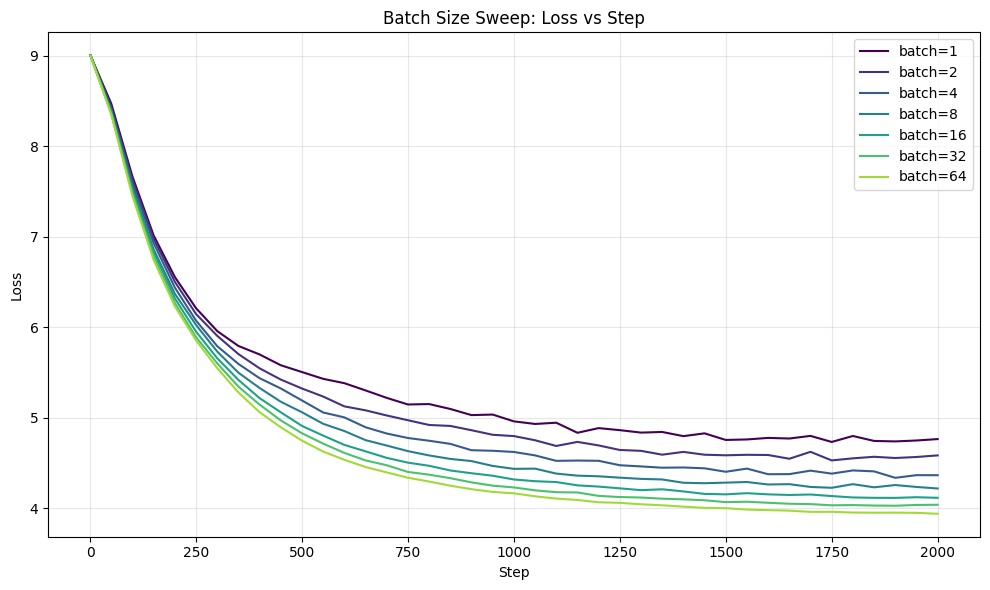

Saved: batch_sweep_vs_step.png


In [7]:
# Plot 1: Loss vs Step (how fast does each batch size learn per step?)
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis([i/len(results) for i in range(len(results))])
for r, color in zip(results, colors):
    ax.plot(r["steps"], r["losses"], 
            color=color, linewidth=1.5, 
            label=f"batch={r['batch_size']}")

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Batch Size Sweep: Loss vs Step')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('batch_sweep_vs_step.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: batch_sweep_vs_step.png")

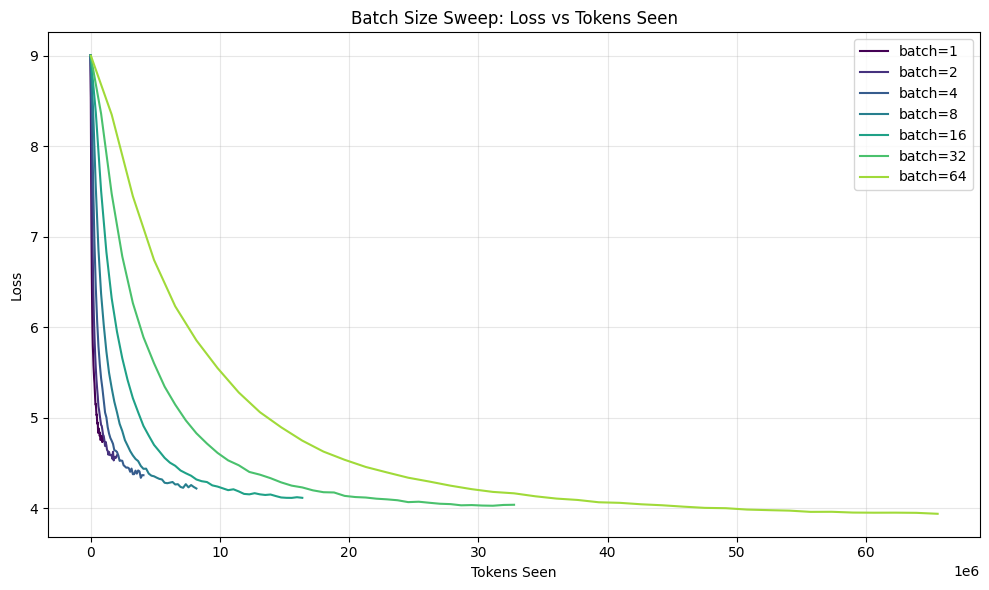

Saved: batch_sweep_vs_tokens.png


In [8]:
# Plot 2: Loss vs Tokens Seen (normalizing for data consumption)
fig, ax = plt.subplots(figsize=(10, 6))

for r, color in zip(results, colors):
    tokens_seen = [s * r["tokens_per_step"] for s in r["steps"]]
    ax.plot(tokens_seen, r["losses"], 
            color=color, linewidth=1.5, 
            label=f"batch={r['batch_size']}")

ax.set_xlabel('Tokens Seen')
ax.set_ylabel('Loss')
ax.set_title('Batch Size Sweep: Loss vs Tokens Seen')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.ticklabel_format(style='scientific', axis='x', scilimits=(6,6))

plt.tight_layout()
plt.savefig('batch_sweep_vs_tokens.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: batch_sweep_vs_tokens.png")

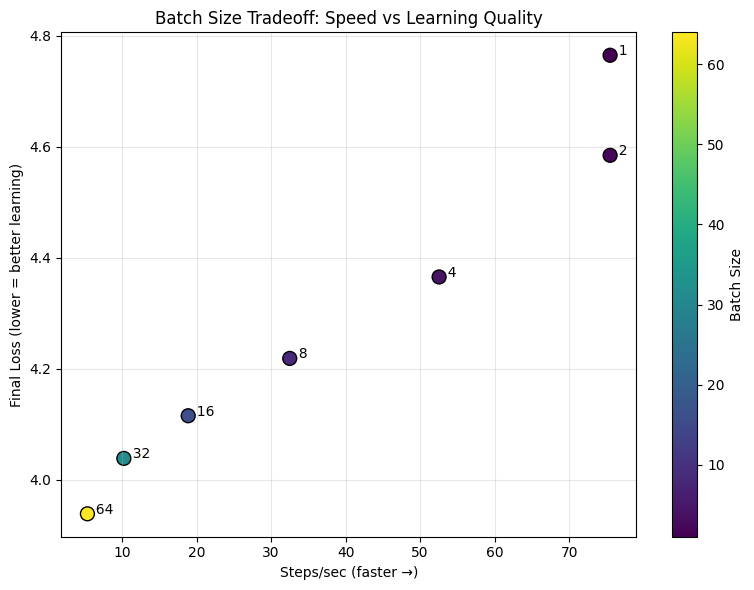

Saved: batch_sweep_tradeoff.png


In [9]:
# Plot 3: The tradeoff - Steps/sec vs Final Loss
fig, ax = plt.subplots(figsize=(8, 6))

batch_sizes = [r["batch_size"] for r in results]
steps_per_sec = [r["steps_per_sec"] for r in results]
final_losses = [r["final_loss"] for r in results]

scatter = ax.scatter(steps_per_sec, final_losses, c=batch_sizes, 
                     cmap='viridis', s=100, edgecolors='black')

# Label each point with batch size
for r in results:
    ax.annotate(f"  {r['batch_size']}", 
                (r['steps_per_sec'], r['final_loss']),
                fontsize=10)

ax.set_xlabel('Steps/sec (faster →)')
ax.set_ylabel('Final Loss (lower = better learning)')
ax.set_title('Batch Size Tradeoff: Speed vs Learning Quality')
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Batch Size')

plt.tight_layout()
plt.savefig('batch_sweep_tradeoff.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: batch_sweep_tradeoff.png")

## Conclusion

Questions to answer:

1. **Which batch sizes actually learn?** (Loss < 5.0 at step 2000)
2. **What's the throughput sweet spot?** (Max steps/sec among learners)
3. **Does tokens/sec tell a different story?** (Efficiency of data consumption)
4. **Is there a Pareto frontier?** (Can't get faster without worse loss)

Pick the winner for future experiments.